#DCASE2020 data download

In [1]:
import tarfile, shutil
import zipfile
import sys, os, urllib.request, tarfile, glob
import numpy as np
import cv2
import librosa
import librosa.core
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt

class SOUND:
    def __init__(self, download_dir, path):
        self.path = "data/"
        self.binary_dir = os.path.join(download_dir, "binary")

        if not os.path.exists(download_dir):
            os.mkdir(download_dir)
        if not os.path.exists(self.binary_dir):
            os.mkdir(self.binary_dir)

        # download file
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (source_path,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()

        source_path = path
        dest_path = os.path.join(download_dir, "binary.zip")
        urllib.request.urlretrieve(source_path, filename=dest_path, reporthook=_progress)
        # untar
        with zipfile.ZipFile(dest_path) as existing_zip:
            existing_zip.extractall(self.path)

# wav file Input
def file_load(wav_name, mono=False):
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

def make_data(folder_name, id_name):
    result = []
    all_name = glob.glob(folder_name)
    for name in all_name:
        if id_name in name:
            result.append(file_load(name)[0])
    return np.array(result)
    
# change wave data to stft
def to_sp(x, n_fft=512, hop_length=256):
    stft = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    sp = librosa.amplitude_to_db(np.abs(stft))
    return sp

def to_img(x):
    result = []
    for i in range(len(x)):
        result.append(cv2.resize(to_sp(x[i]), (224,224)))
    return np.array(result)

In [2]:
##############################
# input machine and id for your purpose

machine = "slider" # fan, pump, valve, ToyCar, ToyConveyor
id_no = "id_00" # id02, id04, id06, id01, id03
##############################

In [3]:
if machine == "fan":
    print("FAN data download...")
    DATA = SOUND("./ad", "https://zenodo.org/record/3678171/files/dev_data_fan.zip?download=1")
elif machine == "valve":
    print("\n VALVE data download...")
    DATA = SOUND("./ad", "https://zenodo.org/record/3678171/files/dev_data_valve.zip?download=1")
elif machine == "pump":
    print("\n Pump data download...")
    DATA = SOUND("./ad", "https://zenodo.org/record/3678171/files/dev_data_pump.zip?download=1")
elif machine == "slider":
    print("\n Slider data download...")
    DATA = SOUND("./ad", "https://zenodo.org/record/3678171/files/dev_data_slider.zip?download=1")
elif machine == "ToyCar":
    print("\n Toycar data download...")
    DATA = SOUND("./ad", "https://zenodo.org/record/3678171/files/dev_data_ToyCar.zip?download=1")
else:
    print("\n Toyconveyor data download...")
    DATA = SOUND("./ad", "https://zenodo.org/record/3678171/files/dev_data_ToyConveyor.zip?download=1")

print("\n Loading Data...")
x_train = make_data("data/" + machine + "/train/*", id_no)
x_test_normal = make_data("data/" + machine + "/test/*", "normal_" + id_no)
x_test_anomaly = make_data("data/" + machine + "/test/*", "anomaly_" + id_no)

# data normalization
max_ = 15.6#np.max(x_train)
min_ = -74.7#np.min(x_train)

X_train = (to_img(x_train)-min_)/(max_-min_)
X_test_normal = (to_img(x_test_normal)-min_)/(max_-min_)
X_test_anomaly = (to_img(x_test_anomaly)-min_)/(max_-min_)

mean = 133.4
sigma = 31.595366

X_train = (X_train*255-mean)/sigma
X_test_normal = (X_test_normal*255-mean)/sigma
X_test_anomaly = (X_test_anomaly*255-mean)/sigma

print(np.mean(X_train), np.std(X_train))

X_train = np.expand_dims(X_train, axis=-1)
X_test_normal = np.expand_dims(X_test_normal, axis=-1)
X_test_anomaly = np.expand_dims(X_test_anomaly, axis=-1)

print(X_train.shape)


 Slider data download...
 Loading Data...
-0.1748957 0.87170863
(968, 224, 224, 1)


#Pre-trained model download

In [4]:
!git clone https://github.com/shinmura0/DCASE2020_Task2_Solution-Anomaly_detection-

Cloning into 'DCASE2020_Task2_Solution-Anomaly_detection-'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [5]:
from keras.models import model_from_json
model_path = "DCASE2020_Task2_Solution-Anomaly_detection-/model/" 

Using TensorFlow backend.


#Generate anomaly sound

In [6]:
import random
import pandas as pd

# add white noise
def add_whitenoise(x, rate=0.002):
    return to_sp(x + rate*np.random.randn(len(x)))

# add pink noise
# https://www.dsprelated.com/showarticle/908.php
def add_pinknoise(x, ncols=11, alpha=0.002):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    nrows = len(x)
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return to_sp(alpha * total.values + x)

# add random line
def draw_line(x, length=[5,20], thickness_length=[2,4]):
    result = np.copy(x)
    width = x.shape[1]
    height = x.shape[0]
    angle = [0, np.pi/2, np.pi, np.pi*3/2]
    np.random.shuffle(angle)

    length = np.random.randint(length[0],length[1])
    x1 = random.randint(length, width-length)
    x2 = x1 + length*np.cos(angle[0])
    y1 = random.randint(length, height-length)
    y2 = y1 + length*np.sin(angle[0])

    thickness = random.randint(thickness_length[0], thickness_length[1])
    color1 = float(np.max(x))

    cv2.line(result, (x1,y1), (int(np.min([width,x2])),int(np.min([height,y2]))), color1, thickness)

    return result

# change Hz to average
def average_Hz(x, length=[2,4]):
    result = np.copy(x)
    height = x.shape[0]

    length = np.random.randint(length[0],length[1])
    begin = np.random.randint(0, height-length)
    for i in range(length):
        result[begin+i] = np.mean(result[begin+i])

    return result

def normalization(x):
    max_ = 15.6#np.max(x_train)
    min_ = -74.7#np.min(x_train)
    mean = 133.4
    sigma = 31.595366

    result = cv2.resize(x, (224, 224))
    result = (result-min_)/(max_-min_)
    return (result*255-mean)/sigma

def to_img2(x):
    result = cv2.resize(to_sp(x), (224,224))
    return np.array(result)

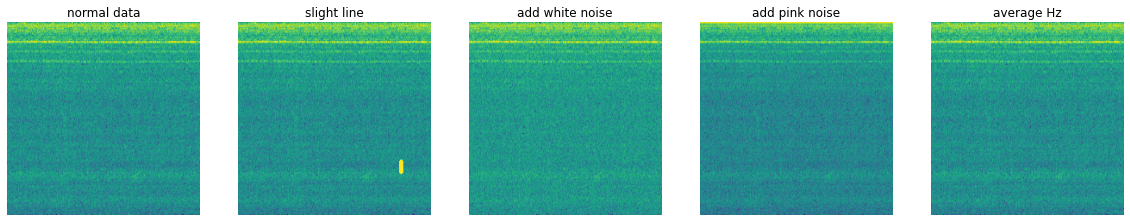

In [7]:
target = np.copy(x_train[0])

img0 = to_img2(target)
img0 = normalization(img0)

img1 = draw_line(img0)

img2 = add_whitenoise(target)
img2 = normalization(img2)

img3 = add_pinknoise(target)
img3 = normalization(img3)

img4 = average_Hz(img0)

plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.axis("off")
plt.title("normal data")
plt.imshow(img0)

plt.subplot(1,5,2)
plt.axis("off")
plt.title("slight line")
plt.imshow(img1)

plt.subplot(1,5,3)
plt.axis("off")
plt.title("add white noise")
plt.imshow(img2)

plt.subplot(1,5,4)
plt.axis("off")
plt.title("add pink noise")
plt.imshow(img3)

plt.subplot(1,5,5)
plt.axis("off")
plt.title("average Hz")
plt.imshow(img4)
plt.show()

#Self-Supervised-Learing

In [8]:
from keras.applications import MobileNetV2
from sklearn.cluster import KMeans
from keras.engine.topology import Layer
from keras import backend as K
from keras.layers import Input, GlobalAveragePooling2D, Activation
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import array_to_img
import tensorflow as tf
import keras
from sklearn import metrics

def train_CNN(model, x, class_=2, batch_size=32):
    acc = []
    epochs = int(6000/len(x))
    print("training...")
    
    for epochnumber in range(epochs):
        temp_acc = []
        
        # data shuffle
        np.random.shuffle(x)
    
        for i in range(int(len(x) / batch_size)):
            
            # load batch
            x_batch = x[i*batch_size:i*batch_size+batch_size]
            X_batch = []

            for j in range(len(x_batch)):
                img = to_img2(x_batch[j])
                img = normalization(img)
                X_batch.append(img) 
            X_batch = np.array(X_batch)

            # generate anomaly sound
            x_random = []
            for j in range(120):
                no = random.randint(0, len(x_batch)-1)
                rand = np.random.randint(4)
                if rand == 0:# random line
                    img = to_img2(x_batch[no])
                    img = normalization(img)
                    img = draw_line(img)
                    x_random.append(img)
                elif rand == 1:# white noise
                    img = add_whitenoise(x_batch[no])
                    img = normalization(img)
                    x_random.append(img)
                elif rand == 2:# pink noise
                    img = add_pinknoise(x_batch[no])
                    img = normalization(img)
                    x_random.append(img)
                else: # average Hz
                    img = to_img2(x_batch[no])
                    img = normalization(img)
                    img = average_Hz(img)
                    x_random.append(img)

            x_random = np.array(x_random)

            # Hard sample
            Y = np.zeros([len(x_random), 2])
            Y[:,1] = 0
            x_random = np.expand_dims(x_random, axis=-1)
            score = model.predict([x_random, Y])

            adress = np.argsort(score[:,1])
            x_batch_random = []
            for j in range(len(x_batch)):
                x_batch_random.append(x_random[adress[j]])
            X_batch = np.expand_dims(X_batch, axis=-1)
            X = np.vstack((X_batch, np.array(x_batch_random)))

            # make label
            y_batch = np.zeros(2*batch_size)
            y_batch[batch_size:] = 1

            Y = keras.utils.to_categorical(y_batch)

            loss = model.train_on_batch([X, Y], Y)
            score = model.evaluate([X, Y], Y)
            temp_acc.append(score[1])

        acc.append(np.mean(temp_acc))

        if (epochnumber+1) % 5 == 0:
            print("epoch:",epochnumber+1)
            print("Training accuracy:", acc[-1])
                
    # graph
    plt.plot(acc,label="Accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    return model

# concatenate mobilenetV2
def build_arcface(x, base_model):
    #add new layers 
    hidden = base_model.output
    yinput = Input(shape=(2,), name="arcface_input") # for ArcFace
    # stock hidden model
    c = Arcfacelayer(2, 30, 0.05)([hidden,yinput])
    prediction = Activation('softmax')(c)
    model = Model(inputs=[base_model.input, yinput], outputs=prediction)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001, amsgrad=True),
                  metrics=['accuracy'])

    return model

# Aarcface layer
class Arcfacelayer(Layer):
    def __init__(self, output_dim, s=30, m=0.50, easy_margin=False):
        self.output_dim = output_dim
        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        super(Arcfacelayer, self).__init__()

    # make weight
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Arcfacelayer, self).build(input_shape)


    # main 
    def call(self, x):
        y = x[1]
        x_normalize = tf.math.l2_normalize(x[0]) # x = x'/ ||x'||2
        k_normalize = tf.math.l2_normalize(self.kernel) # Wj = Wj' / ||Wj'||2

        cos_m = K.cos(self.m)
        sin_m = K.sin(self.m)
        th = K.cos(np.pi - self.m)
        mm = K.sin(np.pi - self.m) * self.m

        cosine = K.dot(x_normalize, k_normalize) # W.Tx
        sine = K.sqrt(1.0 - K.square(cosine))

        phi = cosine * cos_m - sine * sin_m #cos(θ+m)

        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine) 

        else:
            phi = tf.where(cosine > th, phi, cosine - mm) 

        # correct class:cos(θ+m) other class:cosθ 
        output = (y * phi) + ((1.0 - y) * cosine) 
        output *= self.s

        return output

    def compute_output_shape(self, input_shape):

        return (input_shape[0][0], self.output_dim)

##Evaluate

In [9]:
def get_auc(Z1, Z2):
    y_true = np.zeros(len(Z1)+len(Z2))
    y_true[len(Z1):] = 1#0:normal、1：anomaly

    # FPR, TPR
    fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

    # AUC
    auc = metrics.auc(fpr, tpr)

    return fpr, tpr, auc

def plotroc_arc(model, train, test_normal, test_anomaly, name):
    Z1, Z2 = [], []
    for i in range(len(model)):
        # arcface
        Z1.append(-get_score_arc(model[i], train, test_normal))
        Z2.append(-get_score_arc(model[i], train, test_anomaly))

        fpr, tpr, auc = get_auc(Z1[-1], Z2[-1])
        plt.plot(fpr, tpr, label= str(i) + 'model(AUC = %.4f)'%(auc))

    Z1 = np.mean(Z1, axis=0)
    Z2 = np.mean(Z2, axis=0)
    fpr, tpr, auc = get_auc(Z1, Z2)
    plt.plot(fpr, tpr, label='Ensemble model(AUC = %.4f)'%(auc))

    plt.legend()
    plt.title(name + '(ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

def get_score_arc(model, train, test):
    model = Model(model.get_layer(index=0).input, model.layers[-4].get_output_at(-1)) # delete Arcface
    
    # load normal vector
    hold_vector = model.predict(train)# shape(len(train), 1280)

    # load anomaly vector
    predict_vector = model.predict(test)# shape(len(test), 1280)

    score = []

    for i in range(len(predict_vector)):
        cos_similarity = cosine_similarity(predict_vector[i], hold_vector) # shape(len(test), len(train))
        score.append(np.max(cos_similarity))

    return np.array(score)

def cosine_similarity(x1, x2): 
    if x1.ndim == 1:
        x1 = x1[np.newaxis]
    if x2.ndim == 1:
        x2 = x2[np.newaxis]
    x1_norm = np.linalg.norm(x1, axis=1)
    x2_norm = np.linalg.norm(x2, axis=1)
    cosine_sim = np.dot(x1, x2.T)/(x1_norm*x2_norm+1e-10)
    return cosine_sim

##Experiment

SSL 1/3
training...
64/64 [==============================] - 0s 3ms/step
epoch: 5
Training accuracy: 0.12760416666666666
64/64 [==============================] - 0s 3ms/step


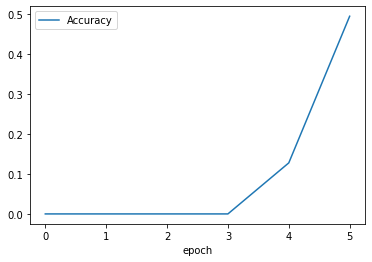

SSL 2/3
training...
64/64 [==============================] - 0s 3ms/step
epoch: 5
Training accuracy: 0.4869791666666667
64/64 [==============================] - 0s 3ms/step


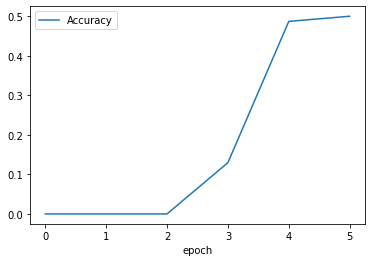

SSL 3/3
training...
64/64 [==============================] - 0s 3ms/step
epoch: 5
Training accuracy: 0.421875
64/64 [==============================] - 0s 3ms/step


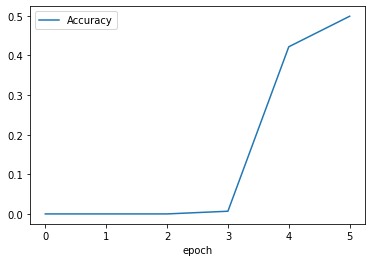

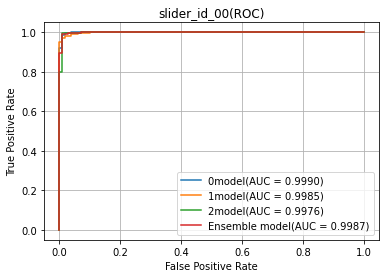

In [10]:
model_arc = []
for i in range(3):
    print("SSL " + str(i+1) + "/3")
    model_pre = model_from_json(open(model_path + 'model.json').read())
    model_pre.load_weights(model_path + 'weights.h5')
    v2 = Model(inputs=model_pre.input, outputs=model_pre.layers[-2].output)
    v2 = build_arcface((2,224,224,1), v2)
    model_arc.append(train_CNN(v2, x_train))

plotroc_arc(model_arc, X_train, X_test_normal, X_test_anomaly, machine + "_" + id_no)

#Faster-Grad-CAM
Faster-Grad-CAM : https://github.com/shinmura0/Faster-Grad-CAM

In [12]:
from sklearn.cluster import KMeans
import time
from keras.preprocessing.image import array_to_img

# faster-grad
def show_result(model, model_small, layer_name, data, no, kmeans, channel_weight, channel_adress, top50=False):
    original, result_faster, score = [], [], []
    for i in range(5):
        original.append(data[no[i]]) 
        img1 = predict_faster_gradcam(data[no[i]], model_small, kmeans, channel_weight, channel_adress)
        result_faster.append(img1)
        #tmp = model.predict([np.expand_dims(data[no[i]], axis=0), [0,1]])
        #score.append(tmp[1])

    original = np.array(original)

    plt.figure(figsize=(20,10))
    for i in range(5):
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.imshow(original[i,:,:,0])
    for i in range(5):
        plt.subplot(2,5,i+6)
        plt.axis("off")
        #plt.title(score[i])
        plt.imshow(array_to_img(result_faster[i]))
    plt.show()

def train_faster_gradcam(x_normal, x_anomaly, model, clusters=10):
    # Arcfaceを削除
    model_embed = Model(model.get_layer(index=0).input, [model.layers[-13].get_output_at(-1), model.layers[-4].get_output_at(-1)])

    # pa class data
    _, vector_normal = model_embed.predict(x_normal)

    # gu class data
    _, vector_anomaly = model_embed.predict(x_anomaly)# shape[(len(x), 3, 3, 480), (len(x), 1280)]

    # k-means
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(vector_anomaly)
    labels = kmeans.labels_

    # channel database
    channel_weight, channel_adress = [], []
    temp_weight = np.zeros((clusters, 480))# 480="block_16_expand_relu".output
    print("Making Database...")
    for i in range(len(labels)):
        # x_anomalyについて一個ずつ重みを加算していく
        _, weight, _ = GradCam(model, x_anomaly[i], "block_16_expand_relu", 1, False)
        temp_weight[labels[i]] += weight #要確認
        print(i+1,"/",len(labels))

    for i in range(clusters):
        number = np.where(labels == i, 1, 0) #クラスタ内の個数
        average_weight = temp_weight[i] / np.sum(number) #重みの平均
        weight_adress = np.argsort(average_weight)
        channel_adress.append(weight_adress[-50:])
        channel_weight.append(average_weight[weight_adress[-50:]])

    return model_embed, kmeans, np.array(channel_weight), np.array(channel_adress), vector_normal

def predict_faster_gradcam(x, model, kmeans, channel_weight, channel_adress):
    channel_out, vector = model.predict(np.expand_dims(x, axis=0))
    channel_out = channel_out[0]
    cluster_no = kmeans.predict(vector)
    # レイヤーのアウトプットに乗じる
    cam = np.dot(channel_out[:,:,channel_adress[cluster_no][0]], channel_weight[cluster_no][0])

    # ヒートマップにして合成
    cam = cv2.resize(cam, (x.shape[1], x.shape[0]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    
    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    binary = (x - np.min(x)) / (np.max(x)-np.min(x))
    binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
    jetcam = (np.float32(jetcam) + binary*255 / 2)   # もとの画像に合成

    return jetcam

def GradCam(model, x, layer_name, class_, top50):
    X = np.expand_dims(x,axis=0)
    
    # 前処理
    target = np.array([0, 1]).reshape((1,-1))
    class_idx = class_
    class_output = model.output[:, class_idx]
    
    # 勾配を取得
    before = time.time()
    conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([model.input[0],model.input[1]], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数
    
    output, grads_val = gradient_function([X, target])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    if top50 == True:
        label = np.argsort(weights)
        cam = np.dot(output[:,:,label[-50:]], weights[label[-50:]])
    else:
        cam = np.dot(output, weights)

    # ヒートマップにして合成
    cam = cv2.resize(cam, (x.shape[1], x.shape[0]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    
    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    binary = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
    jetcam = (np.float32(jetcam) + binary*255 / 2)   # もとの画像に合成

    return jetcam, weights, time.time()-before

## generate anomaly sound

In [15]:
X_train_anomaly = []

for i in range(50):
    rand = np.random.randint(4)
    if rand == 0:# random line
        img = to_img2(x_train[i])
        img = normalization(img)
        img = draw_line(img)
        X_train_anomaly.append(img)
    elif rand == 1:# white noise
        img = add_whitenoise(x_train[i])
        img = normalization(img)
        X_train_anomaly.append(img)
    elif rand == 2:# pink noise
        img = add_pinknoise(x_train[i])
        img = normalization(img)
        X_train_anomaly.append(img)
    else: # average Hz
        img = to_img2(x_train[i])
        img = normalization(img)
        img = average_Hz(img)
        X_train_anomaly.append(img)

X_train_anomaly = np.expand_dims(np.array(X_train_anomaly), axis=-1)

##Experiment

In [16]:
model_grad, kmeans, channel_weight, channel_adress, vector_normal = train_faster_gradcam(X_train[:50], X_train_anomaly[:50], model_arc[0])

Making Database...
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


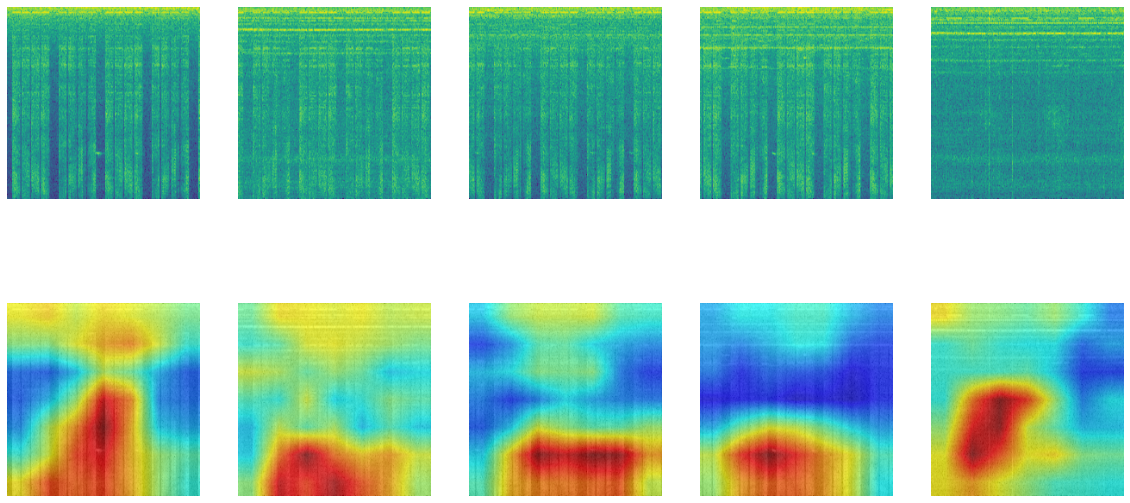

In [17]:
show_result(model_arc[0], model_grad, "block_16_expand_relu", X_test_anomaly, [10,11,12,13,18], kmeans, channel_weight, channel_adress)

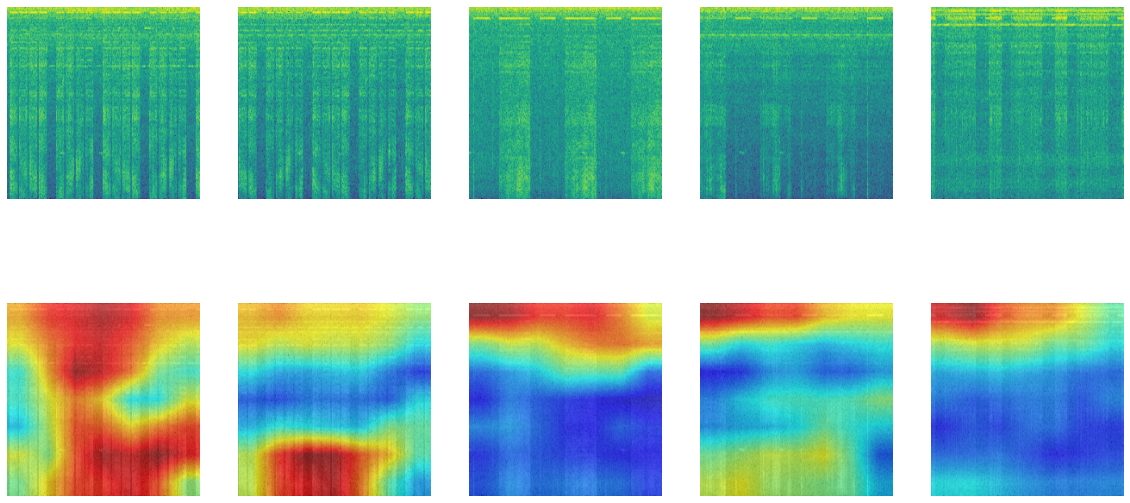

In [18]:
show_result(model_arc[0], model_grad, "block_16_expand_relu", X_test_anomaly, [20,21,22,23,28], kmeans, channel_weight, channel_adress)